
### Training data

The original datasets are part of https://camelyon17.grand-challenge.org/Data/ 
The training is done using tensorflow on GoogleColab Notebooks


In [5]:
# Fixing bug issue
pip install setuptools==45.3.0
# Install the OpenSlide C library and Python bindings
apt-get install openslide-tools
pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random

from os import listdir
from os.path import isfile, join

In [9]:
# Read all tumor files 
mypath = "/content/drive/My Drive/slides/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles_tum = list(map(lambda x: x[:9] if x[-3:]=="tif"  else None , onlyfiles)) # extracts the unique files

onlyfiles_list= list(set(onlyfiles_tum))
onlyfiles_list.remove(None)
onlyfiles_list

['tumor_016',
 'tumor_023',
 'tumor_012',
 'tumor_002',
 'tumor_057',
 'tumor_005',
 'tumor_059',
 'tumor_078',
 'tumor_064',
 'tumor_001',
 'tumor_035',
 'tumor_081',
 'tumor_019',
 'tumor_084',
 'tumor_094',
 'tumor_075',
 'tumor_096',
 'tumor_101',
 'tumor_091',
 'tumor_038',
 'tumor_110',
 'tumor_031']

In [10]:
slide_list = []
mask_list = []
for tum in onlyfiles_list:
    slide = tum +'.tif' 
    tumor_mask = tum+'_mask.tif' 
  
    slide_url = "/content/drive/My Drive/slides/" + slide #+ tum +'.tif'
    mask_url = "/content/drive/My Drive/slides/" + tumor_mask # tum+'_mask.tif'

  # Download the whole slide image
  # if not os.path.exists(slide):
  #   !curl -O $slide_url

  # # Download the tumor mask
  # if not os.path.exists(tumor_mask):
  #   !curl -O $mask_url

    if os.path.exists(slide_url) and os.path.exists(mask_url): # only this file is has slide & its mask image
        slide = open_slide(slide_url)
        print("Read WSI from %s with width: %d, height: %d" % (slide, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(mask_url)
    #print(f"Read tumor mask from {tumor_mask_path}" )
    #print("Slide includes %d levels", len(slide.level_dimensions))
    print(f"Slide includes {len(slide.level_dimensions)} levels") # check this

    slide_list.append(slide)
    mask_list.append(tumor_mask)


Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_016.tif') with width: 97792, height: 221184
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_023.tif') with width: 97792, height: 221184
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_012.tif') with width: 97792, height: 215552
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_002.tif') with width: 97792, height: 219648
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_057.tif') with width: 97792, height: 220672
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_005.tif') with width: 97792, height: 219648
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_059.tif') with width: 97280, height: 221184
Slide includes 10 levels
Read WSI from OpenSlide('/content/drive/My Drive/slides/tumor_078.tif') with width:

In [11]:
# Total unique files
len(slide_list), len(mask_list)

(21, 21)

In [12]:
# type of image files
type(slide), type(tumor_mask)

(openslide.OpenSlide, openslide.OpenSlide)

In [13]:
# function to assert all dimensions are correct
def dimensions_assertion(slide, tumor_mask ):
    print("Total dimensions", len(slide.level_dimensions))
    for i in range(len(slide.level_dimensions)):
        print("Level %d, dimensions: %s downsample factor %d" % (i, ##The difeerent levels correspond to different downsample sizes
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

   # Verify downsampling works as expected
    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [18]:
# function to read entire slide images
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

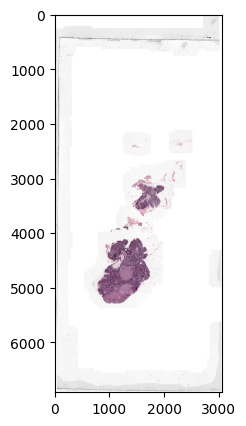

In [20]:
# Usecase; zoom level 5
slide = slide_list[i]
level = 5

slide_image_5 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])


plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image_5)
plt.show()

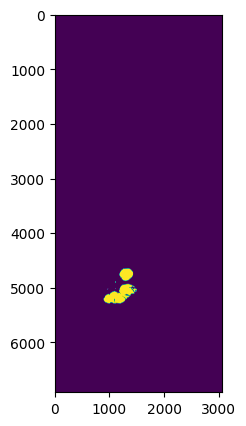

In [21]:
# Example: read the entire mask at the same zoom level

tumor_mask = mask_list[i]
mask_image_5 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image_5[:,:,0] # can use 1,2 also

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)
plt.show()

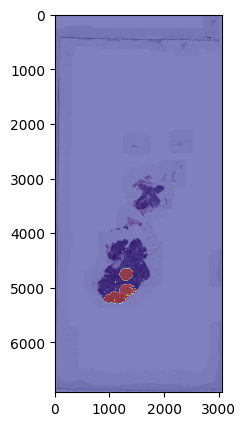

In [22]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image_5)
plt.imshow(mask_image_5[:,:,0], cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.show()

In [23]:
# Function to calculate percentage of image 
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity) # subset indices having color [0:black -> 1:white]: i.e tissue present
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image_5)
percent_tissue = len(tissue_pixels) / float(slide_image_5.shape[0] * slide_image_5.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 



1090668 tissue_pixels pixels (2.3 percent of the image)


In [36]:
tissue_pixels[:10]

[(0, 2834),
 (0, 2835),
 (0, 2836),
 (0, 2837),
 (0, 2838),
 (0, 2839),
 (0, 2840),
 (0, 2841),
 (0, 2842),
 (0, 2843)]

### Steps
1. create a sliding windows over the non grey region 
2. for each classify as c/nc based on the mask
3. create heatmap

In [24]:
def create_tile(slide_image, mask_image):
    sz=299
    result = []
    shape = slide_image.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(slide_image,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                  constant_values=255)
    mask = np.pad(mask_image,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
              constant_values=0)

    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
  
    N= 15 #  could be based on certain intensity threshold also
    if len(img) < N:
        print("Initial Shape",img.shape, mask.shape)
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
        print("After padding Shape",img.shape, mask.shape)
  
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i})

    return result

In [25]:
# Creating 15 tiles
all_slides = []
for i in range(len(slide_list)):
    for level in range(4,7): # only using zoom levels 4,5,6

    print(i, level)

    #slide 
    slide_image_level = read_slide(slide_list[i], 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

    mask_image_level = read_slide(mask_list[i]  , 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
     
    result = create_tile(slide_image_level, mask_image_level)
    all_slides.extend(result)



0 4
0 5
0 6
1 4
1 5
1 6
2 4
2 5
2 6
3 4
3 5
3 6
4 4
4 5
4 6
5 4
5 5
5 6
6 4
6 5
6 6
7 4
7 5
7 6
8 4
8 5
8 6
9 4
9 5
9 6
10 4
10 5
10 6
11 4
11 5
11 6
12 4
12 5
12 6
13 4
13 5
13 6
14 4
14 5
14 6
15 4
15 5
15 6
16 4
16 5
16 6
17 4
17 5
17 6
18 4
18 5
18 6
19 4
19 5
19 6
20 4
20 5
20 6


In [27]:
len(all_slides)

945

In [30]:
result_final = []
for i in range(len(all_slides)):
  #print(i)
  if all_slides[i]['img'].mean() < 230.0 and all_slides[i]['img'].mean() > 100.0:
    result_final.append(all_slides[i])


In [38]:
valid_list = [result_final.pop(random.randrange(len(result_final))) for _ in range(10)]

In [126]:
len(valid_list), len(result_final)

(10, 419)

In [39]:
# save these as train and validation
for i in range(len(valid_list)):
    img_temp = Image.fromarray(valid_list[i]['img'])
    mask_temp = valid_list[i]['mask'][:,:,0]
    if mask_temp.mean() > 0.0:
        img_temp.save('/content/sample_data/validation/cancer_1/' +str(i)+'image.png') 
        print(i,"cancer detected")
    else:
        img_temp.save('/content/sample_data/validation/cancer_0/' +str(i)+'image.png') 
        print(i,"NO cancer")



0 NO cancer
1 NO cancer
2 NO cancer
3 cancer detected
4 NO cancer
5 NO cancer
6 cancer detected
7 NO cancer
8 NO cancer
9 NO cancer


In [40]:
# save these as train and validation
for i in range(len(result_final)):
    mg_temp = Image.fromarray(result_final[i]['img'])
    mask_temp = result_final[i]['mask'][:,:,0]
    if mask_temp.mean() > 0.0:
        img_temp.save('/content/sample_data/train/cancer_1/' +str(i)+'image.png') 
        print(i,"cancer detected")
    else:
        img_temp.save('/content/sample_data/train/cancer_0/' +str(i)+'image.png') 
        print(i,"NO cancer")



0 NO cancer
1 NO cancer
2 cancer detected
3 NO cancer
4 cancer detected
5 NO cancer
6 NO cancer
7 cancer detected
8 NO cancer
9 NO cancer
10 NO cancer
11 cancer detected
12 cancer detected
13 NO cancer
14 cancer detected
15 cancer detected
16 NO cancer
17 cancer detected
18 cancer detected
19 cancer detected
20 NO cancer
21 NO cancer
22 NO cancer
23 NO cancer
24 NO cancer
25 NO cancer
26 NO cancer
27 cancer detected
28 NO cancer
29 cancer detected
30 NO cancer
31 NO cancer
32 NO cancer
33 cancer detected
34 NO cancer
35 NO cancer
36 NO cancer
37 cancer detected
38 NO cancer
39 NO cancer
40 NO cancer
41 NO cancer
42 NO cancer
43 NO cancer
44 NO cancer
45 NO cancer
46 cancer detected
47 cancer detected
48 NO cancer
49 NO cancer
50 cancer detected
51 cancer detected
52 NO cancer
53 NO cancer
54 NO cancer
55 NO cancer
56 NO cancer
57 NO cancer
58 NO cancer
59 NO cancer
60 NO cancer
61 cancer detected
62 cancer detected
63 NO cancer
64 NO cancer
65 cancer detected
66 NO cancer
67 NO cancer


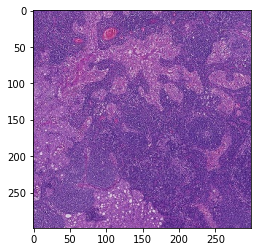

In [ ]:
img_temp = result[0]['img']
plt.imshow(img_temp)

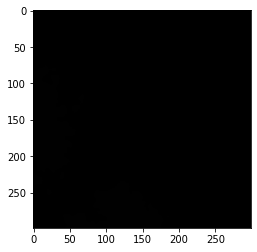

In [ ]:
mask_temp = result[0]['mask']
plt.imshow(mask_temp)

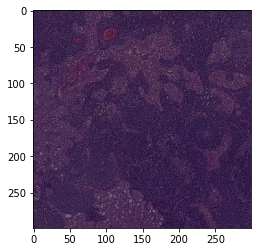

In [ ]:
#plt.figure(figsize=(5,5), dpi=100)
plt.imshow(img_temp)
plt.imshow(mask_temp, cmap='jet', alpha=0.5) 

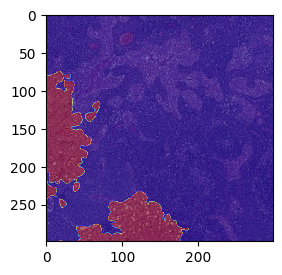

In [ ]:
plt.figure(figsize=(3,3), dpi=100)
img_temp = result[0]['img']
mask_temp = result[0]['mask'][:,:,0]
plt.imshow(img_temp)
plt.imshow(mask_temp, cmap='jet', alpha=0.5) 
plt.show()

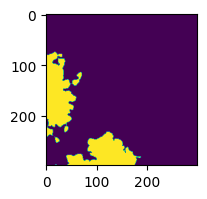

In [ ]:
mask_temp = result[0]['mask']
mask_temp_image = mask_temp[:,:,0] # can use 1,2 also

plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_temp_image)
plt.show()

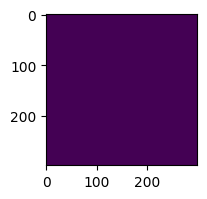

0.0

In [ ]:
mask_temp = result[8]['mask'][:,:,0]
#mask_temp_image = mask_temp[:,:,0] # can use 1,2 also
plt.figure(figsize=(2,2), dpi=100)
plt.imshow(mask_temp)
plt.show()
mask_temp.mean()

### Training Model

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
# train model on cancer present data : using Transfer learning
IMG_SIZE = 299
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [43]:
base_model.trainable = False


In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(2)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [45]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [48]:
train_data_dir = '/content/sample_data/train/'
train_datagen = ImageDataGenerator(rescale=1./255)

valid_data_dir = '/content/sample_data/validation/'
valid_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(299, 299),
                                                        batch_size=900,
                                                        class_mode='categorical')

Found 419 images belonging to 2 classes.


In [54]:
valid_generator = valid_datagen.flow_from_directory(valid_data_dir,
                                                        target_size=(299, 299),
                                                        batch_size=30,
                                                        class_mode='categorical')

Found 10 images belonging to 2 classes.


In [55]:
train_generator.class_indices, valid_generator.class_indices

({'cancer_0': 0, 'cancer_1': 1}, {'cancer_0': 0, 'cancer_1': 1})

In [56]:
#Plot This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
sample_training_images, _ = next(train_generator)

In [58]:
sample_training_images[0].mean(), sample_training_images[1].mean(),sample_training_images[2].mean()

(0.40415603, 0.85112363, 0.8355991)

In [59]:
sample_training_images[4].mean(), sample_training_images[5].mean()

(0.4476542, 0.66484785)

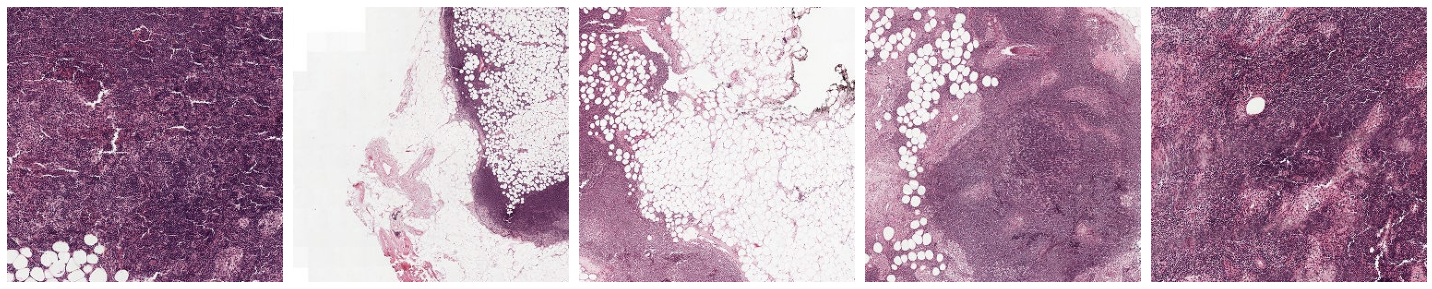

In [60]:
plotImages(sample_training_images[0:5]) #fine tune the intensity to drop the 1st image

In [ ]:
sample_training_images.shape

(50, 299, 299, 3)

In [61]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # when labeling is numerical: What loss should you be using here?
              metrics=['accuracy'])

In [62]:
model.fit(train_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 4.0171 - accuracy: 0.3795 - val_loss: 3.5283 - val_accuracy: 0.3000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 3.5891 - accuracy: 0.3795 - val_loss: 6.9130 - val_accuracy: 0.2000
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 3.0701 - accuracy: 0.3866 - val_loss: 5.3791 - val_accuracy: 0.2000
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 2.2524 - accuracy: 0.4821 - val_loss: 2.4649 - val_accuracy: 0.3000
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 1.3386 - accuracy: 0.5800 - val_loss: 0.7968 - val_accuracy: 0.6000
